# California Socioeconomic Relations Dataset
#### Luke Kearney, Tiger Cross, Joon-Ho Son, Theo Cohen, Jonas Scholz

***

- [1. Introduction](#intro)
    - [1.1 Dataset Background](#background)
    - [1.2 Project Structure](#structure)
- [2. Data Preparation](#data-preparation)
    - [2.1 Overview of Features](#data-features)
    - [2.2 Incomplete Data](#data-incomplete)
- [3. Feature Selection](#feature-selection)    
- [4. Exploratory data analysis](#data-analysis)
- [5. Case Study](#case-study)
- [6. Classification](#classification)
- [7. Summary](#summary)


TODO: TALK ABOUT MARGIN OF ERROR SOMEWHERE

***
## 1. Introduction<a class="anchor" id="intro"></a>
### 1.1 Dataset Background<a class="anchor" id="background"></a>


The given dataset consists of geodatabase data that combines data from the 2012-2016 American Community Survey (ACS) 5-year estimates and Topologically Integrated Geographic Encoding and Referencing (TIGER) Shapefiles. It can be found at https://www.census.gov/programs-surveys/acs/.

The ACS carry out this supplemental survey every year. More information about these surveys can be found at https://www.census.gov/programs-surveys/acs/. The 5-year estimates that comprises this data is an aggregation of 60 months of ACS data.

We began the task by getting a high level overview of the features. This notebook will explore various correlations discovered during analysis of the provided dataset, and in particular will have a focus on investigating factors affecting **educational attainment**. 

### 1.2 Project Structure<a class="anchor" id="structure"></a>

```Python
data/
data/raw/ # Raw data
data/interim/ # Interim data
data/processed/ # Processed data
imgs/ # Saved images
notebooks/
README.md
src/
```

***
## 2. Data Preparation<a class="anchor" id="data-processing"></a>
### 2.1 Overview of Features<a class="anchor" id="data-overview"></a>

We used pandas and dictionaries available in python to map the long column names for each csv into a more readable table so we could identify the different column names for each table that we could try and find a correlation between: 

In [1]:
# Standard python packages
import os
import sys
from pathlib import Path # For portable paths

# Other package imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
data_folder = Path("../data/")
raw_data_folder = data_folder / "raw" / "train"

metadata = pd.read_csv(raw_data_folder / "BG_METADATA_2016.csv")

In [3]:
def replace_columns(df):
    """
    Replace the 'short name' of each column of a given data frame with the 'long name' in the metadata file  
    
    Args:
        df: The dataframe to reformat headings on.
        
    Returns:
        The dataframe with reformatted headings.
    """
    labels = pd.Series(metadata["Full_Name"].values,index=metadata["Short_Name"]).to_dict()
    df = df.rename(columns=labels)
    return df

In [4]:
dfs = {}

for f in os.listdir(str(raw_data_folder)):
    print("Reformatted columns names of {}".format(f))
    df = pd.read_csv(raw_data_folder / f)
    df = replace_columns(df)
    dfs[f] = df

Reformatted columns names of X99_IMPUTATION.csv
Reformatted columns names of X07_MIGRATION.csv
Reformatted columns names of X01_AGE_AND_SEX.csv
Reformatted columns names of X03_HISPANIC_OR_LATINO_ORIGIN.csv
Reformatted columns names of X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv
Reformatted columns names of X08_COMMUTING.csv
Reformatted columns names of X20_EARNINGS.csv
Reformatted columns names of X12_MARITAL_STATUS_AND_HISTORY.csv
Reformatted columns names of BG_METADATA_2016.csv
Reformatted columns names of X19_INCOME.csv
Reformatted columns names of X14_SCHOOL_ENROLLMENT.csv
Reformatted columns names of X15_EDUCATIONAL_ATTAINMENT.csv
Reformatted columns names of X17_POVERTY.csv
Reformatted columns names of X22_FOOD_STAMPS.csv
Reformatted columns names of X21_VETERAN_STATUS.csv
Reformatted columns names of X16_LANGUAGE_SPOKEN_AT_HOME.csv
Reformatted columns names of X02_RACE.csv
Reformatted columns names of X27_HEALTH_INSURANCE.csv
Reformatted columns names of X23_EMPLOYMENT_STATUS.csv


We identified our overall response variable `y` as The *population over the age of 25 that have attained a bachelors degree or higher*, This is from the following table:

In [5]:
dfs['X15_EDUCATIONAL_ATTAINMENT.csv']["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Total: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]

0        1981
1         712
2         566
3         882
4         811
5         324
6         800
7        1063
8         604
9         845
10       1295
11        283
12        244
13        493
14        249
15        293
16        365
17        323
18        309
19        581
20        331
21        471
22        363
23        418
24        235
25        265
26        442
27        224
28        179
29        237
         ... 
18968     485
18969      23
18970     573
18971     540
18972     285
18973     434
18974       0
18975     912
18976     464
18977     490
18978     397
18979     363
18980     370
18981     601
18982     563
18983     269
18984     355
18985     305
18986     411
18987     738
18988     124
18989     260
18990     457
18991     261
18992     439
18993     696
18994     492
18995     666
18996     171
18997     371
Name: SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Total: POPULATION 25 YEARS AND OVER WITH A BA

## 2.2 Incomplete Data

The first step in preparing any dataset for use is to deal with missing values. We can gain an overall impression of the quanitity of incomplete data by calculating the percentage of rows/columns that contains a missing value.

In [6]:
def percent_na(df):
    """
    Prints percentage of rows and columns that contain a NaN value for a given dataframe 
    
    Args:
        df: The dataframe to calculate percentages for.
        
    Returns:
        A tuple of the percentage of rows and columns that contain a NaN value.
    """
    # Find rows and columns that contain a NaN value
    narows = df[df.isnull().any(axis=1)]
    nacols = df.columns[df.isna().any()].tolist()
    # Calculate the percentage of rows and columns that contain a NaN value
    percent_narows = round(len(narows)/df.shape[0]*100, 1)
    percent_nacols = round(len(nacols)/df.shape[1]*100, 1)
    return (percent_narows, percent_nacols)

In [7]:
for (name, df) in dfs.items():
    percent_narows, percent_nacols = percent_na(df)
    print(f"Percent missing data for {name} : rows={percent_narows}% columns={percent_nacols}%")

Percent missing data for X99_IMPUTATION.csv : rows=100.0% columns=2.5%
Percent missing data for X07_MIGRATION.csv : rows=100.0% columns=50.3%
Percent missing data for X01_AGE_AND_SEX.csv : rows=100.0% columns=36.8%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=100.0% columns=7.5%
Percent missing data for X20_EARNINGS.csv : rows=22.5% columns=18.3%
Percent missing data for X12_MARITAL_STATUS_AND_HISTORY.csv : rows=0.0% columns=0.0%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X19_INCOME.csv : rows=100.0% columns=26.3%
Percent missing data for X14_SCHOOL_ENROLLMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X15_EDUCATIONAL_ATTAINMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X17_POVERTY.csv : rows=98.7% columns=3.3%
Percent missing data for

From this, we can see that some tables contain a very large proportion of rows with NaN values. For example, `X19_INCOME.csv` has 100% of its rows containing a NaN value.

After cheecking the percentage of missing data in rows and columns for each of the CSVs, we decided to drop the columns that had 20% or greater NaN values, as these were deemed too incomplete to be of significant use.

In [8]:
dfs_no_na = {}
for (name, df) in dfs.items():
    threshold=len(df)*0.8 # Keep columns with at least 80% data
    dfs_no_na[name] = df.dropna(thresh=threshold, axis=1) 
    print(f"{name} columns dropped : {dfs[name].shape[1] - dfs_no_na[name].shape[1]}")
    
del dfs # Free up some memory for my poor laptop

X99_IMPUTATION.csv columns dropped : 14
X07_MIGRATION.csv columns dropped : 82
X01_AGE_AND_SEX.csv columns dropped : 36
X03_HISPANIC_OR_LATINO_ORIGIN.csv columns dropped : 0
X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv columns dropped : 0
X08_COMMUTING.csv columns dropped : 44
X20_EARNINGS.csv columns dropped : 0
X12_MARITAL_STATUS_AND_HISTORY.csv columns dropped : 0
BG_METADATA_2016.csv columns dropped : 0
X19_INCOME.csv columns dropped : 61
X14_SCHOOL_ENROLLMENT.csv columns dropped : 0
X15_EDUCATIONAL_ATTAINMENT.csv columns dropped : 0
X17_POVERTY.csv columns dropped : 10
X22_FOOD_STAMPS.csv columns dropped : 0
X21_VETERAN_STATUS.csv columns dropped : 0
X16_LANGUAGE_SPOKEN_AT_HOME.csv columns dropped : 0
X02_RACE.csv columns dropped : 0
X27_HEALTH_INSURANCE.csv columns dropped : 0
X23_EMPLOYMENT_STATUS.csv columns dropped : 0
X00_COUNTS.csv columns dropped : 0
X11_HOUSEHOLD_FAMILY_SUBFAMILIES.csv columns dropped : 0


For the remaining incomplete data, our approach involved a basic imputation technique, filling each NaN with the mean value of that column. This method has clear disadvantages (in particular, decreasing the variance of the data), but in the interests of time we deemed this to be the most appropriate solution.

In [9]:
for (name, df) in dfs_no_na.items():
    dfs_no_na[name] = df.fillna(df.mean())

We perform a quick sanity check to ensure there are no more NaN values in the datasets and save the processed data.

In [10]:
for (name, df) in dfs_no_na.items():
    percent_narows, percent_nacols = percent_na(df)
    print(f"Percent missing data for {name} : rows={percent_narows}% columns={percent_nacols}%")

Percent missing data for X99_IMPUTATION.csv : rows=0.0% columns=0.0%
Percent missing data for X07_MIGRATION.csv : rows=0.0% columns=0.0%
Percent missing data for X01_AGE_AND_SEX.csv : rows=0.0% columns=0.0%
Percent missing data for X03_HISPANIC_OR_LATINO_ORIGIN.csv : rows=0.0% columns=0.0%
Percent missing data for X09_CHILDREN_HOUSEHOLD_RELATIONSHIP.csv : rows=0.0% columns=0.0%
Percent missing data for X08_COMMUTING.csv : rows=0.0% columns=0.0%
Percent missing data for X20_EARNINGS.csv : rows=0.0% columns=0.0%
Percent missing data for X12_MARITAL_STATUS_AND_HISTORY.csv : rows=0.0% columns=0.0%
Percent missing data for BG_METADATA_2016.csv : rows=0.0% columns=0.0%
Percent missing data for X19_INCOME.csv : rows=0.0% columns=0.0%
Percent missing data for X14_SCHOOL_ENROLLMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X15_EDUCATIONAL_ATTAINMENT.csv : rows=0.0% columns=0.0%
Percent missing data for X17_POVERTY.csv : rows=0.0% columns=0.0%
Percent missing data for X22_FOOD_STAMPS

for (name, df) in dfs_no_na.items():
    df.to_csv(data_folder / "processed" / name)
    print(f"Saved {name}")

## 4. Exploratory Data Analysis<a class="anchor" id="data-analysis"></a>

When calculating the correlation between any of our features, we decided to use the Pearson correlation coefficient as we looked into using both the kendall tau and spearmans correlation methods, but did not want to relate ordinal data or data that follows a monotonic function. As part of our feature selection process, we Initially looked at the correlations within individual CSVs to see which features had a similar correlation to each other so we could drop one of those as they would follow the same pattern with our response variable and pollute our results.

In [11]:
processed_data_folder = Path("../data/processed/")

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

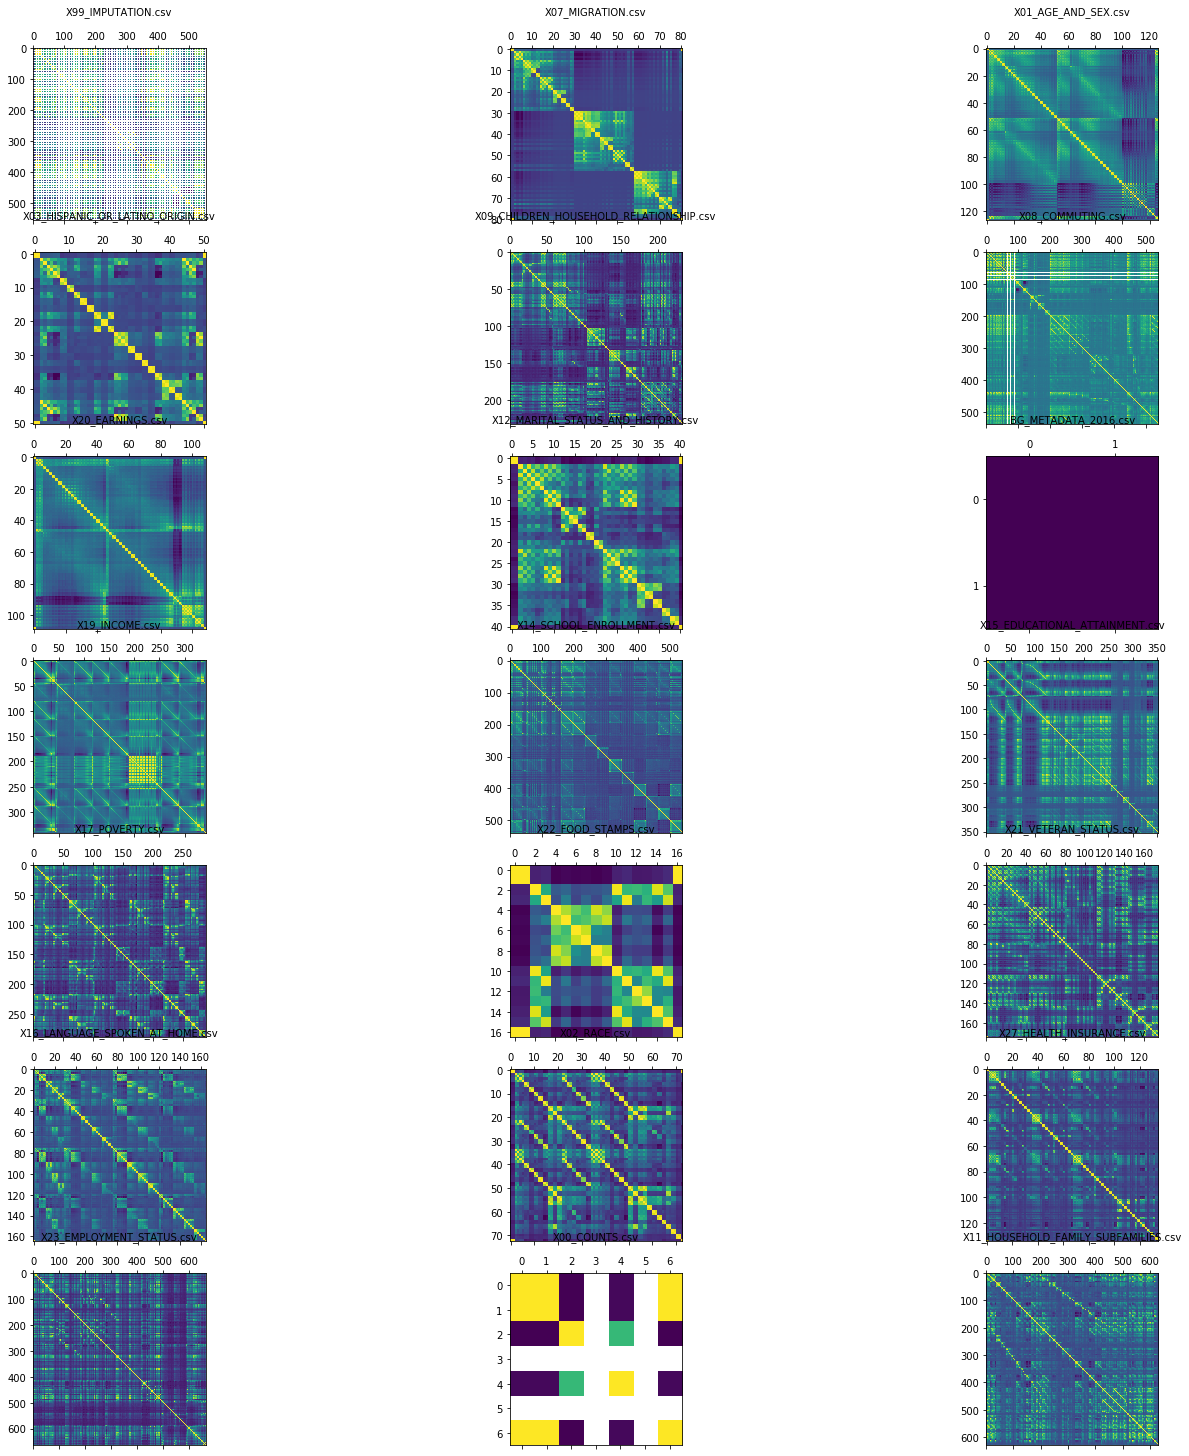

In [12]:
## WHAT THE FUCK IS WRONG HERE
def plot_corr_matrices(data_path):
    fig, axarr = plt.subplots(7,3, figsize=(20, 20))
    fig.tight_layout()
    
    ## Takes a loooong time to run
    for i, f in enumerate(os.listdir(str(data_path))):
        df = pd.read_csv(data_path / f)
        row = i // 3
        col = i % 3
        ax = axarr[row, col]
        ax.matshow(df.corr())
        ax.set_title(f, fontsize=10, pad=25)
    plt.show()

plot_corr_matrices(processed_data_folder)        

We then iterated through the correlation matrices and dropped features of similar correlation (similar colours in above heatmaps), This narrowed our dataset down a great deal and allowed us to focus more on the correlation of multiple features easier. We considered that it may have made our data more generic, although, we still considered more detailed features as shown when we train our model and in the case study

We decided to explore all of the different CSVs and observe which features has the greatest correlation with our chosen y values

In [ ]:
def find_educational_attainment_correlation(characteristic_csv_filepath, edu_attainment_csv_filepath, truncation_index = False, education_standard = 'bachelors'):
    '''
    education_standard = 'bachelors' or 'masters' or 'higher_education'
    '''

    edu_attainment = pd.read_csv(edu_attainment_csv_filepath)
    characteristic = pd.read_csv(characteristic_csv_filepath)

    no_bachelors = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Bachelor's degree: Population 25 years and over -- (Estimate)"]
    no_masters = edu_attainment["EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER: Master's degree: Population 25 years and over -- (Estimate)"]
    no_higher_ed = no_masters + no_bachelors

    edu_population = edu_attainment[edu_attainment.columns[3]]
    char_population = characteristic[characteristic.columns[3]]

    if truncation_index == False:
        truncation_index = len(no_masters)

    fractional_bachelors = no_bachelors/edu_population
    fractional_masters = no_masters/edu_population

    if education_standard == 'bachelors':
        y = no_bachelors[0:truncation_index]
    if education_standard == 'masters':
        y = no_masters[0:truncation_index]
    else:
        y = no_higher_ed[0:truncation_index]

    correlations = []
    column_name = []


    for column in characteristic.columns[4:]:
        absolute_x = characteristic[column][0:truncation_index]
        fractional_x = absolute_x/char_population[0:truncation_index]
        correlations.append(np.corrcoef(absolute_x, y)[0][1])
        column_name.append(characteristic[column].name)

    df = pd.DataFrame(correlations, column_name, columns = ['correlation'])
    '''
    returns max correlating factor, all correlations,
    '''

    return df.sort_values('correlation', ascending = False)

In [ ]:
poverty_file = processed_data_folder / "X17_POVERTY.csv"
education_file = processed_data_folder / "X15_EDUCATIONAL_ATTAINMENT.csv"
correlations_df = find_educational_attainment_correlation(str(poverty_file), str(education_file), truncation_index=False, education_standard='higher_education')

In [ ]:
plt.barh(correlations_df.index[:10], correlations_df["correlation"].values[:10])
plt.show()

# Case Study 1: How gross income per capita affects educational attainment<a class="anchor" id="case-study"></a>

## Case Study 2: How the educational attainment has been correlated to gender over time<a class="anchor" id="case-study"></a>

For this case study, we have studied that percentage of the population who graduated from a bachelor degree or higher given their gender and their age. Therefore, we can evaluate the evolution of educational attainment over time for each gender.
Note that the database only provides information for 3 age frames which are 25 to 39, 40 to 64 and 65 and over. Hence, we are missing the generation currently attending univeristy (18 to 24 years old). We have looked at the school enrollment csv file which do provides the amount of attendance to universities for males and females but we decided to not trust this data as it has an average margin of error higher than 80%. Therefore, we couldn't complete the evolution up to the present time.

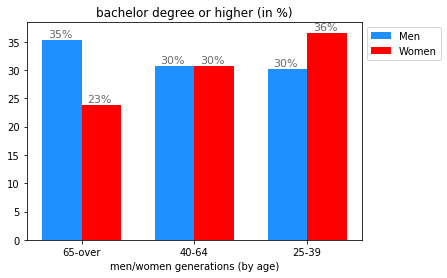

In [15]:
edu_attainment_csv_filepath = processed_data_folder / "X15_EDUCATIONAL_ATTAINMENT.csv"
sex_csv_filepath = processed_data_folder / "X01_AGE_AND_SEX.csv"

edu_attainment = pd.read_csv(str(edu_attainment_csv_filepath))
sex_data = pd.read_csv(str(sex_csv_filepath))

women_25_39 = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Female: 25 to 39 years: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]
women_40_64 = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Female: 40 to 64 years: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]
women_65_over = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Female: 65 years and over: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]

women_total = sex_data["SEX BY AGE: Female: Total population -- (Estimate)"]
women_total_18_24 = sex_data["SEX BY AGE: Female: 18 and 19 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 20 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 21 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 22 to 24 years: Total population -- (Estimate)"]
women_total_25_39 = sex_data["SEX BY AGE: Female: 25 to 29 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 30 to 34 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 35 to 39 years: Total population -- (Estimate)"]
women_total_40_64 = sex_data["SEX BY AGE: Female: 40 to 44 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 45 to 49 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 50 to 54 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 55 to 59 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 60 and 61 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 62 to 64 years: Total population -- (Estimate)"]
women_total_65_over = sex_data["SEX BY AGE: Female: 65 and 66 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 67 to 69 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 70 to 74 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 75 to 79 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 80 to 84 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Female: 85 years and over: Total population -- (Estimate)"]

women_25_39_ratio = sum(women_25_39) / sum(women_total_25_39) * 100
women_total_40_64_ratio = sum(women_40_64) / sum(women_total_40_64) * 100
women_total_65_over_ratio = sum(women_65_over) / sum(women_total_65_over) * 100

y_women = [women_total_65_over_ratio, women_total_40_64_ratio, women_25_39_ratio]

########

men_25_39 = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Male: 25 to 39 years: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]
men_40_64 = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Male: 40 to 64 years: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]
men_65_over = edu_attainment["SEX BY AGE BY FIELD OF BACHELOR'S DEGREE FOR FIRST MAJOR FOR THE POPULATION 25 YEARS AND OVER: Male: 65 years and over: POPULATION 25 YEARS AND OVER WITH A BACHELOR'S DEGREE OR HIGHER ATTAINMENT -- (Estimate)"]

men_total = sex_data["SEX BY AGE: Male: Total population -- (Estimate)"]
men_total_18_24 = sex_data["SEX BY AGE: Male: 18 and 19 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 20 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 21 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 22 to 24 years: Total population -- (Estimate)"]
men_total_25_39 = sex_data["SEX BY AGE: Male: 25 to 29 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 30 to 34 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 35 to 39 years: Total population -- (Estimate)"]
men_total_40_64 = sex_data["SEX BY AGE: Male: 40 to 44 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 45 to 49 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 50 to 54 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 55 to 59 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 60 and 61 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 62 to 64 years: Total population -- (Estimate)"]
men_total_65_over = sex_data["SEX BY AGE: Male: 65 and 66 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 67 to 69 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 70 to 74 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 75 to 79 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 80 to 84 years: Total population -- (Estimate)"]+ sex_data["SEX BY AGE: Male: 85 years and over: Total population -- (Estimate)"]

men_25_39_ratio = sum(men_25_39) / sum(men_total_25_39) * 100
men_total_40_64_ratio = sum(men_40_64) / sum(men_total_40_64) * 100
men_total_65_over_ratio = sum(men_65_over) / sum(men_total_65_over) * 100

y_men = [men_total_65_over_ratio, men_total_40_64_ratio, men_25_39_ratio]

########

N = 3
fig, ax = plt.subplots()

ind = np.arange(N)    # the x locations for the groups
width = 0.35         # the width of the bars
p1 = ax.bar(ind, y_men, width, color='dodgerblue')
p2 = ax.bar(ind + width, y_women, width,
            color='r')

ax.set_title('bachelor degree or higher (in %)')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(("65-over","40-64" ,"25-39"))

for i in ax.patches:
    ax.text(i.get_x() + 0.05, i.get_height() + 0.5, str(i.get_height()).split(".", 1)[0] + "%", fontsize=11, color='dimgrey')

plt.xlabel('men/women generations (by age)')
ax.legend((p1[0], p2[0]), ('Men', 'Women'), bbox_to_anchor=(1, 1))

plt.show()

Note that the database only provides information for 3 age frames which are 25 to 39, 40 to 64 and 65 and over. Hence, we are missing the generation currently attending univeristy (18 to 24 years old). We have looked at the school enrollment csv file which do provides the amount of attendance to universities for males and females but we decided to not trust this data as it has an average margin of error higher than 80%. Therefore, we couldn't complete the evolution up to the present time.

## Mapping the Data<a class="anchor" id="data-mapping"></a>

## Classification<a class="anchor" id="classification"></a>

## Summary<a class="anchor" id="summary"></a>